In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import networkx as nx

from networkx.algorithms import bipartite
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [2]:
beer_df = pd.read_csv("beer_reviews.csv")
list(beer_df.columns)

['brewery_id',
 'brewery_name',
 'review_time',
 'review_overall',
 'review_aroma',
 'review_appearance',
 'review_profilename',
 'beer_style',
 'review_palate',
 'review_taste',
 'beer_name',
 'beer_abv',
 'beer_beerid']

In [3]:
beer_df = beer_df.rename(columns={'beer_beerid': 'beer_id'})

In [4]:
beer_df.head(4)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_id
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969


In [5]:
beer_df.shape

(1586614, 13)

In [6]:
beer_df.dtypes

brewery_id              int64
brewery_name           object
review_time             int64
review_overall        float64
review_aroma          float64
review_appearance     float64
review_profilename     object
beer_style             object
review_palate         float64
review_taste          float64
beer_name              object
beer_abv              float64
beer_id                 int64
dtype: object

## 1 - Preprocessing, Data Cleaning & Dataset Inspection

#### 1.1 - Column "review_time".

In [7]:
beer_df['review_time'] = pd.to_datetime(beer_df['review_time'], unit="s")
beer_df['review_time'].iloc[-3:]

1586611   2006-10-13 01:21:53
1586612   2006-10-05 04:37:24
1586613   2006-10-04 23:41:59
Name: review_time, dtype: datetime64[ns]

When is the first beer review occurred, and the last one?

In [8]:
str(beer_df['review_time'].dt.date.min()) + ' to ' + str(beer_df['review_time'].dt.date.max())

'1996-08-22 to 2012-01-11'

Check how many observations are there for each year. This can help me deciding whether to subset the data frame.

In [9]:
beer_df.groupby(beer_df['review_time'].dt.year).size()

review_time
1996         1
1998       133
1999        86
2000       119
2001      1999
2002     23140
2003     56958
2004     69701
2005     89116
2006    129648
2007    142404
2008    210099
2009    243402
2010    277072
2011    333072
2012      9664
dtype: int64

#### 1.2 - Check for unique, null, duplicates and infinite values

In [10]:
beer_df.nunique()

brewery_id               5840
brewery_name             5742
review_time           1577960
review_overall             10
review_aroma                9
review_appearance          10
review_profilename      33387
beer_style                104
review_palate               9
review_taste                9
beer_name               56857
beer_abv                  530
beer_id                 66055
dtype: int64

There seems to be a discrepancy between brewery_id and brewery_name, but couldn't come up with a way of solving this discrepancy. How is it possible that there are more `brewery_id` than `brewery_name`?

Remove the `na`.

In [11]:
beer_df.isnull().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_id                   0
dtype: int64

In [12]:
beer_df = beer_df.dropna()

Check for duplicates.

In [13]:
beer_df.duplicated().sum()

0

#### 1.3 - Inspect the distributions

In [14]:
beer_df.describe().round(2)

,brewery_id,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_id
count,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00
mean,3074.31,3.82,3.75,3.85,3.75,3.80,7.04,21405.75
std,5544.34,0.72,0.70,0.61,0.68,0.73,2.32,21780.33
min,1.00,0.00,1.00,0.00,1.00,1.00,0.01,5.00
25%,141.00,3.50,3.50,3.50,3.50,3.50,5.20,1654.00
50%,417.00,4.00,4.00,4.00,4.00,4.00,6.50,12830.00
75%,2298.00,4.50,4.00,4.00,4.00,4.50,8.50,39236.00
max,28003.00,5.00,5.00,5.00,5.00,5.00,57.70,77316.00


Start from the reviews.

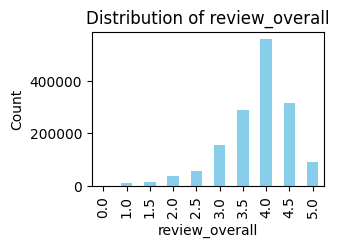

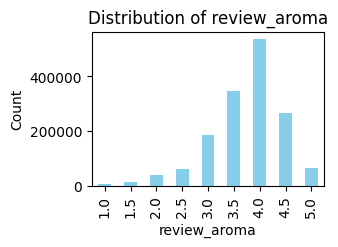

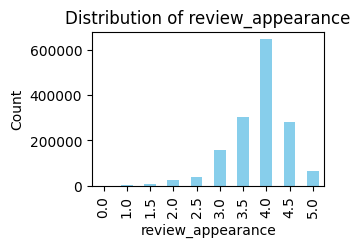

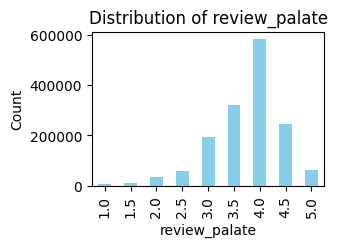

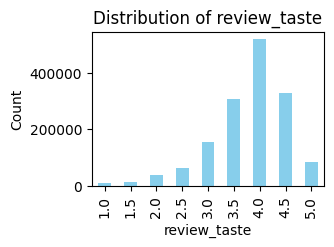

In [15]:
rating_columns = ['review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste']

for column in rating_columns:
    plt.figure(figsize=(3, 2))
    beer_df[column].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

Double check for uncoherent/inconsistent values.

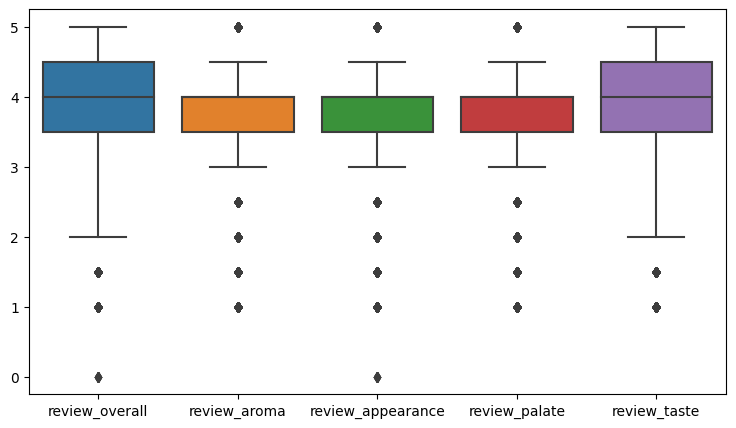

In [16]:
plt.figure(figsize=(9, 5))
sns.boxplot(data=beer_df[['review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste']])
plt.show()

Return the 20 most commont beer styles.

In [17]:
beer_df['beer_style'].value_counts().head(20)

American IPA                        113144
American Double / Imperial IPA       85105
American Pale Ale (APA)              58072
Russian Imperial Stout               53424
American Double / Imperial Stout     50137
American Porter                      46647
American Amber / Red Ale             41731
Belgian Strong Dark Ale              37498
Fruit / Vegetable Beer               31983
American Strong Ale                  31350
Belgian Strong Pale Ale              31323
Saison / Farmhouse Ale               30621
Tripel                               29971
American Adjunct Lager               28964
Witbier                              28654
American Barleywine                  26267
Hefeweizen                           25922
American Brown Ale                   24131
American Pale Wheat Ale              22888
English Pale Ale                     22817
Name: beer_style, dtype: int64

Return the 20 most commont brewery names.

In [18]:
beer_df['brewery_name'].value_counts().head(30)

Boston Beer Company (Samuel Adams)      38806
Dogfish Head Brewery                    33790
Stone Brewing Co.                       33009
Sierra Nevada Brewing Co.               28632
Bell's Brewery, Inc.                    24973
Rogue Ales                              23446
Founders Brewing Company                19951
Victory Brewing Company                 19401
Lagunitas Brewing Company               16766
Avery Brewing Company                   16042
Southern Tier Brewing Company           15856
Anheuser-Busch                          15439
Great Divide Brewing Company            14902
Goose Island Beer Co.                   14208
Three Floyds Brewing Co. & Brewpub      14026
Unibroue                                13915
Brooklyn Brewery                        13719
New Belgium Brewing                     13349
Weyerbacher Brewing Co.                 12185
Flying Dog Brewery                      11690
Tröegs Brewing Company                  11613
Russian River Brewing Company     

In [19]:
beer_df['beer_name'].value_counts().head(100)

90 Minute IPA                          3289
Old Rasputin Russian Imperial Stout    3110
Sierra Nevada Celebration Ale          2999
India Pale Ale                         2960
Two Hearted Ale                        2727
                                       ... 
Yeti Imperial Stout                    1429
Oak Aged Yeti Imperial Stout           1422
Delirium Tremens                       1420
Anchor Liberty Ale                     1417
The Abyss                              1412
Name: beer_name, Length: 100, dtype: int64

Return the 20 most common beer_abv.

In [20]:
beer_df['beer_abv'].value_counts().head(20)

5.0     109116
8.0      67730
6.0      65375
7.0      59446
9.0      59171
5.5      59001
10.0     54772
6.5      48362
5.2      43254
7.5      39973
8.5      38465
5.4      33113
4.9      30894
9.5      29992
4.5      29343
5.3      29075
5.6      28907
5.8      28568
4.8      27092
5.1      25117
Name: beer_abv, dtype: int64

In [21]:
beer_df['review_profilename'].value_counts().head(100)

northyorksammy    5346
mikesgroove       4283
BuckeyeNation     4246
Thorpe429         3273
brentk56          3186
                  ... 
avalon07          1510
Deuane            1504
JoeyBeerBelly     1492
tgbljb            1492
BeerFMAndy        1483
Name: review_profilename, Length: 100, dtype: int64

In [22]:
beer_df['review_time'].dt.year.value_counts().head(20)

2011    322556
2010    268577
2009    235275
2008    201580
2007    135695
2006    122199
2005     83551
2004     64836
2003     52114
2002     20775
2012      9343
2001      1773
2000        98
1998        72
1999        33
1996         1
Name: review_time, dtype: int64

#### 1.4 - Downsampling

### **Option A - keep one year only**

In [23]:
sub_beer_df = beer_df[beer_df['review_time'].dt.year == 2012].copy()
sub_beer_df.shape

(9343, 13)

In [24]:
users_reviews_count = sub_beer_df['review_profilename'].value_counts()
kept_profiles_only = users_reviews_count[users_reviews_count>1].index

In [25]:
sub_beer_df = sub_beer_df[sub_beer_df['review_profilename'].isin(kept_profiles_only)].copy()
sub_beer_df.nunique()

brewery_id            1103
brewery_name          1099
review_time           8600
review_overall           9
review_aroma             9
review_appearance        9
review_profilename    1366
beer_style             102
review_palate            9
review_taste             9
beer_name             3888
beer_abv               216
beer_id               3945
dtype: int64

## 2 - Graph Construction

#### 2.1 - Create the user-beer bipartite graph

In [26]:
G = nx.Graph()

# Add nodes and edges to the graph
for _, row in sub_beer_df.iterrows():
    G.add_node(row['review_profilename'], bipartite='user')
    G.add_node(row['beer_name'], bipartite='beer')
    G.add_edge(row['review_profilename'], row['beer_name'])

nx.bipartite.is_bipartite(G)

True

In [27]:
print(G)

Graph with 5254 nodes and 8641 edges


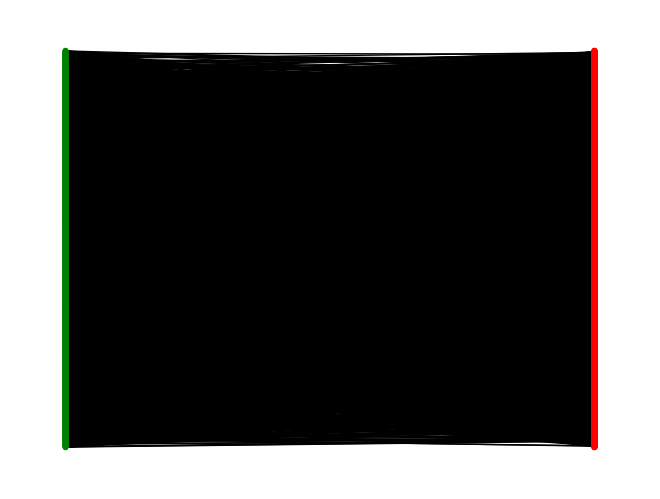

In [28]:
user_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 'user'}
beer_nodes = set(G) - user_nodes

node_colors = ['green' if d['bipartite'] == 'user' else 'red' for n, d in G.nodes(data=True)]

nx.draw(G, pos=nx.bipartite_layout(G, user_nodes), node_color = node_colors, node_size=10)

#### 2.2 - Projections

In [29]:
user_projection = nx.Graph()
user_projection = nx.bipartite.projected_graph(G, user_nodes)

beer_projection = nx.Graph()
beer_projection = nx.bipartite.projected_graph(G, beer_nodes)

Visualize the user projection

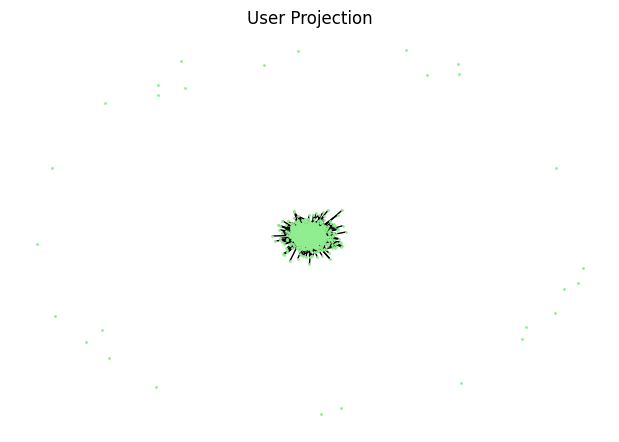

In [30]:
plt.figure(figsize=(6, 4))
pos_user = nx.spring_layout(user_projection)
nx.draw(user_projection, pos=pos_user, node_color='lightgreen', edge_color='black', node_size=1)
plt.title('User Projection')
plt.show()

In [31]:
print(user_projection)

Graph with 1366 nodes and 19237 edges


Visualize the beer projection

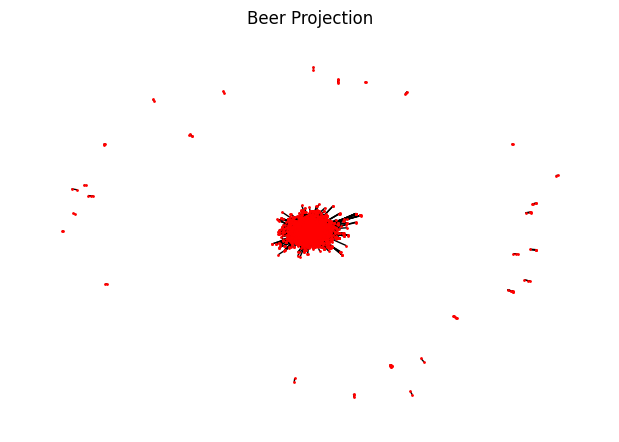

In [32]:
plt.figure(figsize=(6, 4))
pos_beer = nx.spring_layout(beer_projection)
nx.draw(beer_projection, pos=pos_beer, node_color='red', edge_color='black', node_size=1)
plt.title('Beer Projection')
plt.show()

In [33]:
print(beer_projection)

Graph with 3888 nodes and 54238 edges


## 3 - Basic Graph Properties

#### 3.1 - Density

Density for the user graph.

In [34]:
user_density = nx.density(user_projection)
user_density

0.020634026783367926

Density for the beer graph.

In [35]:
beer_density = nx.density(beer_projection)
beer_density

0.007177824996479771

#### 3.2 - Degree Statistics

Degree statistics for the user graph.

In [36]:
user_degree = np.array([d for _, d in user_projection.degree()])

print(f"Avg User Degree: {np.mean(user_degree)}")
print(f"Min User Degree: {np.min(user_degree)}")
print(f"Max User Degree: {np.max(user_degree)}")
print(f"Median User Degree: {np.median(user_degree)}")
print(f"Std User Degree: {np.std(user_degree)}")

Avg User Degree: 28.16544655929722
Min User Degree: 0
Max User Degree: 186
Median User Degree: 19.0
Std User Degree: 26.874206843518703


Degree statistics for the beer graph.

In [37]:
beer_degree = np.array([d for _, d in beer_projection.degree()])

print(f"Avg Beer Degree: {np.mean(beer_degree)}")
print(f"Min Beer Degree: {np.min(beer_degree)}")
print(f"Max Beer Degree: {np.max(beer_degree)}")
print(f"Median Beer Degree: {np.median(beer_degree)}")
print(f"Std Beer Degree: {np.std(beer_degree)}")

Avg Beer Degree: 27.900205761316872
Min Beer Degree: 1
Max Beer Degree: 356
Median Beer Degree: 15.0
Std Beer Degree: 32.77587596426909


#### 3.3 - Degree Distribution

In [38]:
def plot_degree_dist(G, bins):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins=bins)
    plt.show()

Degree distribution of the user graph.

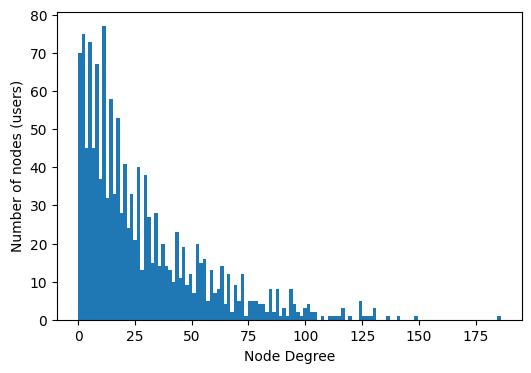

In [39]:
plt.figure(figsize=(6,4))
plt.ylabel('Number of nodes (users)')
plt.xlabel('Node Degree')
plot_degree_dist(user_projection, bins=len(np.unique(user_degree)))

Degree distribution of the beer graph.

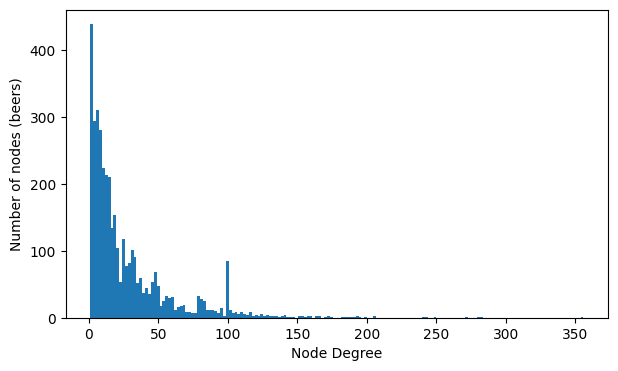

In [40]:
plt.figure(figsize=(7,4))
plt.ylabel('Number of nodes (beers)')
plt.xlabel('Node Degree')
plot_degree_dist(beer_projection, bins=len(np.unique(beer_degree)))

#### 3.4 - Comparison real network (users) vs. random network

From page 25 my notes: start by obtaining $N_{k}$, i.e., the number of nodes with degree $k$. This variable is called `user_degree_count`.

If `user_degree_count` is printed, we can see that there are 171 nodes (users) having degree=0, 145 nodes (users) having degree=1, and so on...

In [41]:
# create a list of degrees associated with each user
user_degree_sequence = list(dict(user_projection.degree()).values())

# initialize a dictionary
user_degree_count = defaultdict(int)

# for each distinct degree, count the number of nodes with that degree
for d in user_degree_sequence:
    user_degree_count[d]+=1

# sort by the keys(items) in ascending order
user_degree_count = dict(sorted(user_degree_count.items()))

The second step consists of computing: $p_k = \frac{N_{k}}{N}$, i.e. the degree distribution - in this case - of the users' nodes.

In [42]:
degree_distribution_users = []

for i in user_degree_count.values():        # i represents N_k
    degree_distribution_users.append(i/user_projection.order())     # N = user_projection.order()

Now that we have everything to plot the degree distribution of the real network, we need an equivalent random network and use it to make comparison.

In [43]:
# generate a RN(N=N, p=density)
random_network_user = nx.gnp_random_graph(n=user_projection.order(), p=user_density)
print(random_network_user)

Graph with 1366 nodes and 19408 edges


Repeat the same steps done for the random network.

In [44]:
# create a list of degrees associated with each user
random_network_user_degree_sequence = list(dict(random_network_user.degree()).values())

# initialize a dictionary
random_network_user_degree_count = defaultdict(int)

# for each distinct degree, count the number of nodes with that degree
for d in random_network_user_degree_sequence:
    random_network_user_degree_count[d]+=1

# sort by the keys(items) in ascending order
random_network_user_degree_count = dict(sorted(random_network_user_degree_count.items()))

In [45]:
degree_distribution_random_network_users = []

for i in random_network_user_degree_count.values():        # i represents N_k
    degree_distribution_random_network_users.append(i/random_network_user.order())     # N = user_projection.order()

Finally visualize the two distributions.

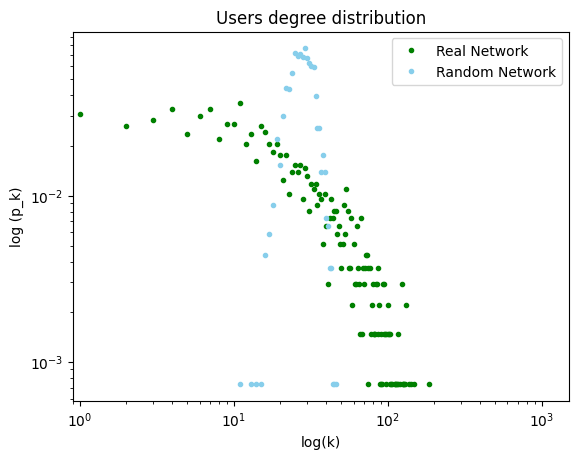

In [46]:
plt.loglog(user_degree_count.keys(), degree_distribution_users, 
           'o', label='Real Network', color='green', markersize=3)
plt.loglog(random_network_user_degree_count.keys(), degree_distribution_random_network_users,
           'o', label='Random Network', color='skyblue', markersize=3)
plt.ylabel('log (p_k)')
plt.xlabel('log(k)')
plt.legend()
plt.title('Users degree distribution')
plt.xlim(0.9,1500)
plt.show()

#### 3.5 - Comparison real network (beers) vs. random network

From page 25 my notes: start by obtaining $N_{k}$, i.e., the number of nodes with degree $k$. This variable is called `beer_degree_count`.

If `beer_degree_count` is printed, we can see that there are 171 nodes (users) having degree=0, 145 nodes (users) having degree=1, and so on...

In [47]:
# create a list of degrees associated with each beer
beer_degree_sequence = list(dict(beer_projection.degree()).values())

# initialize a dictionary
beer_degree_count = defaultdict(int)

# for each distinct degree, count the number of nodes with that degree
for d in beer_degree_sequence:
    beer_degree_count[d]+=1

# sort by the keys(items) in ascending order
beer_degree_count = dict(sorted(beer_degree_count.items()))

The second step consists of computing: $p_k = \frac{N_{k}}{N}$, i.e. the degree distribution - in this case - of the beers' nodes.

In [48]:
degree_distribution_beers = []

for i in beer_degree_count.values():        # i represents N_k
    degree_distribution_beers.append(i/beer_projection.order())     # N = beer_projection.order()

Now that we have everything to plot the degree distribution of the real network, we need an equivalent random network and use it to make comparison.

In [49]:
# generate a RN(N=N, p=density)
random_network_beer = nx.gnp_random_graph(n=beer_projection.order(), p=beer_density)
print(random_network_beer)

Graph with 3888 nodes and 54800 edges


Repeat the same steps done for the random network.

In [50]:
# create a list of degrees associated with each beer
random_network_beer_degree_sequence = list(dict(random_network_beer.degree()).values())

# initialize a dictionary
random_network_beer_degree_count = defaultdict(int)

# for each distinct degree, count the number of nodes with that degree
for d in random_network_beer_degree_sequence:
    random_network_beer_degree_count[d]+=1

# sort by the keys(items) in ascending order
random_network_beer_degree_count = dict(sorted(random_network_beer_degree_count.items()))

In [51]:
degree_distribution_random_network_beers = []

for i in random_network_beer_degree_count.values():        # i represents N_k
    degree_distribution_random_network_beers.append(i/random_network_beer.order())     # N = user_projection.order()

Finally visualize the two distributions.

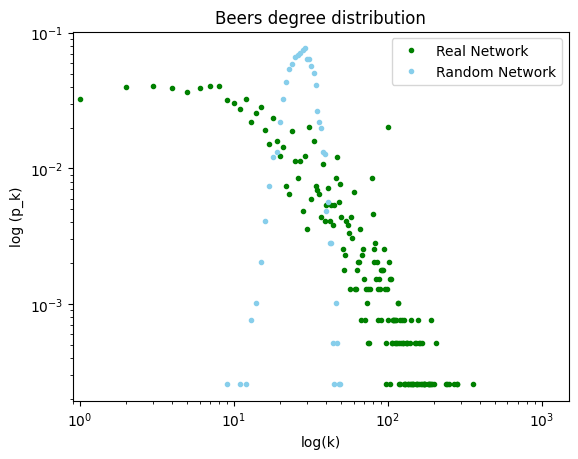

In [52]:
plt.loglog(beer_degree_count.keys(), degree_distribution_beers, 
           'o', label='Real Network', color='green', markersize=3)
plt.loglog(random_network_beer_degree_count.keys(), degree_distribution_random_network_beers,
           'o', label='Random Network', color='skyblue', markersize=3)
plt.ylabel('log (p_k)')
plt.xlabel('log(k)')
plt.legend()
plt.title('Beers degree distribution')
plt.xlim(0.9,1500)
plt.show()

# 4 - Centrality

- degree centrality
- closeness centrality
- betweenness centrality
- eigenvector centrality

In [130]:
def centrality_revealer(centrality_measure, n=5):
    centrality_measure=list(centrality_measure.items())
    centrality_measure.sort(key=lambda x:x[1], reverse=True)
    centrality_measure = [(node,round(value, 2)) for node, value in centrality_measure]
    print(centrality_measure[:n])

#### 4.1 - Centrality measures on the `users` graph.

In [59]:
deg_cent_users = nx.degree_centrality(user_projection)
clo_cent_users = nx.closeness_centrality(user_projection)
bet_cent_users = nx.betweenness_centrality(user_projection)
eig_cent_users = nx.eigenvector_centrality(user_projection)

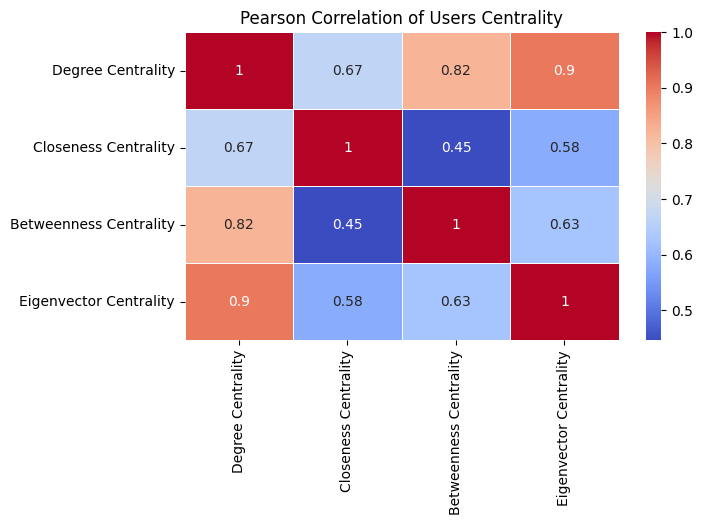

In [150]:
centrality_data_user = {
    'Degree Centrality': list(deg_cent_users.values()),
    'Closeness Centrality': list(clo_cent_users.values()),
    'Betweenness Centrality': list(bet_cent_users.values()),
    'Eigenvector Centrality': list(eig_cent_users.values())
}

# Convert the data to a DataFrame
centrality_user_df = pd.DataFrame(centrality_data_user)

# Compute the Pearson correlation matrix
cm_user = centrality_user_df.corr()

# Set up a seaborn heatmap for visualization
plt.figure(figsize=(7, 4))
sns.heatmap(cm_user, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Pearson Correlation of Users Centrality')
plt.show()

Who are the most central users according to the corresponding centrality measures?

In [145]:
print('Degree Centrality: ')
centrality_revealer(deg_cent_users)
print(' ')
print('Closeness Centrality:')
centrality_revealer(clo_cent_users)
print(' ')
print('Betweenness Centrality:')
centrality_revealer(bet_cent_users)
print(' ')
print('Eigenvector Centrality:')
centrality_revealer(eig_cent_users)

Degree Centrality: 
[('Knapp85', 0.14), ('gtermi', 0.11), ('kojevergas', 0.1), ('tsauce2', 0.1), ('StoneBrewFanatic', 0.1)]
 
Closeness Centrality:
[('Knapp85', 0.49), ('kojevergas', 0.48), ('mdaschaf', 0.48), ('gtermi', 0.48), ('dogfishandi', 0.47)]
 
Betweenness Centrality:
[('Knapp85', 0.04), ('kojevergas', 0.02), ('DrinkSlurm', 0.02), ('gtermi', 0.02), ('jmarsh123', 0.02)]
 
Eigenvector Centrality:
[('StoneBrewFanatic', 0.14), ('Tucquan', 0.13), ('marlinsfan4', 0.12), ('dogfishandi', 0.11), ('socon67', 0.11)]


#### 4.2 - Centrality measures on the `beers` graph.

In [146]:
deg_cent_beers = nx.degree_centrality(beer_projection)
clo_cent_beers = nx.closeness_centrality(beer_projection)
bet_cent_beers = nx.betweenness_centrality(beer_projection)
eig_cent_beers = nx.eigenvector_centrality(beer_projection)

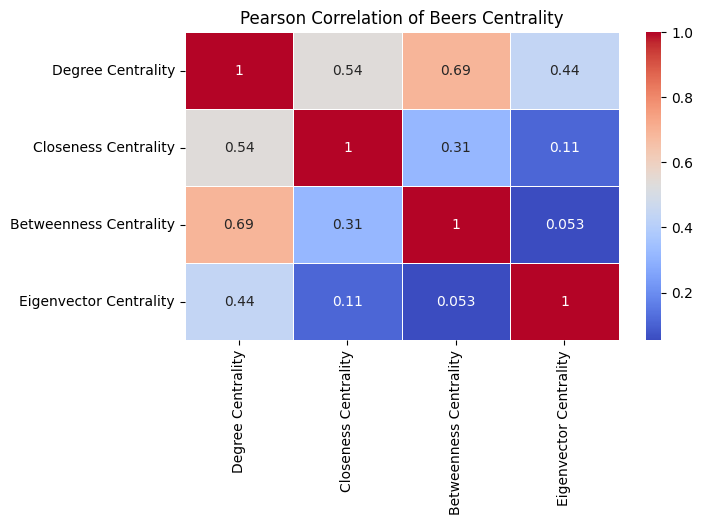

In [149]:
centrality_data_beers = {
    'Degree Centrality': list(deg_cent_beers.values()),
    'Closeness Centrality': list(clo_cent_beers.values()),
    'Betweenness Centrality': list(bet_cent_beers.values()),
    'Eigenvector Centrality': list(eig_cent_beers.values())
}

# Convert the data to a DataFrame
centrality_beer_df = pd.DataFrame(centrality_data_beers)

# Compute the Pearson correlation matrix
cm_beers = centrality_beer_df.corr()

# Set up a seaborn heatmap for visualization
plt.figure(figsize=(7, 4))
sns.heatmap(cm_beers, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Pearson Correlation of Beers Centrality')
plt.show()

Who are the most central users according to the corresponding centrality measures?

In [151]:
print('Degree Centrality: ')
centrality_revealer(deg_cent_beers)
print(' ')
print('Closeness Centrality:')
centrality_revealer(clo_cent_beers)
print(' ')
print('Betweenness Centrality:')
centrality_revealer(bet_cent_beers)
print(' ')
print('Eigenvector Centrality:')
centrality_revealer(eig_cent_beers)

Degree Centrality: 
[('The Alchemist / Ninkasi / Stone - More Brown Than Black IPA', 0.09), ('Sierra Nevada Ruthless Rye IPA', 0.07), ('Lagunitas Sucks Holiday Ale', 0.07), ('Stone 11.11.11 Vertical Epic Ale', 0.07), ('Our Special Ale 2011 (Anchor Christmas Ale)', 0.06)]
 
Closeness Centrality:
[('Lagunitas Sucks Holiday Ale', 0.45), ('The Alchemist / Ninkasi / Stone - More Brown Than Black IPA', 0.45), ('Sierra Nevada Ruthless Rye IPA', 0.44), ('Stone 11.11.11 Vertical Epic Ale', 0.44), ('Dark Intrigue', 0.44)]
 
Betweenness Centrality:
[('The Alchemist / Ninkasi / Stone - More Brown Than Black IPA', 0.04), ('Lagunitas Sucks Holiday Ale', 0.04), ('Sierra Nevada Ruthless Rye IPA', 0.03), ('Stone 11.11.11 Vertical Epic Ale', 0.03), ('Our Special Ale 2011 (Anchor Christmas Ale)', 0.02)]
 
Eigenvector Centrality:
[('Mocha Porter', 0.1), ('Black Butte Porter', 0.1), ('Inversion IPA', 0.1), ('Jubelale', 0.1), ('Chocolate Stout', 0.1)]


# X - **Separator**

### **Option B - keep a certain number only**

Start from keeping 1% of the observations only. It's a huge downsampling, may re-evaluate this.

In [ ]:
sub_beer_df = beer_df.sample(n=1500, replace=False, random_state=40)
sub_beer_df.nunique()

brewery_id             516
brewery_name           516
review_time           1500
review_overall           9
review_aroma             9
review_appearance        9
review_profilename    1160
beer_style              99
review_palate            9
review_taste             9
beer_name             1187
beer_abv               144
beer_id               1198
dtype: int64

In [ ]:
sub_beer_df.shape

(1500, 13)

### **Option C - Stratified Sampling**

In [ ]:
# Calculate the number of reviews per user and per beer
user_review_counts = beer_df['review_profilename'].value_counts()
beer_review_counts = beer_df['beer_name'].value_counts()

# Define a threshold for the minimum number of reviews (adjust as needed)
user_threshold = 1200
beer_threshold = 1200

# Identify users and beers that meet the threshold
selected_users = user_review_counts[user_review_counts >= user_threshold].index
selected_beers = beer_review_counts[beer_review_counts >= beer_threshold].index

# Subset the data based on selected users and beers
sub_beer_df = beer_df[(beer_df['review_profilename'].isin(selected_users)) & (beer_df['beer_name'].isin(selected_beers))]

# Check the size of the filtered dataframe
print(sub_beer_df.shape)

(20264, 13)


In [ ]:
sub_beer_df.nunique()

brewery_id              341
brewery_name            337
review_time           20262
review_overall            9
review_aroma              9
review_appearance         9
review_profilename      156
beer_style               58
review_palate             9
review_taste              9
beer_name               143
beer_abv                 84
beer_id                 505
dtype: int64